In [17]:
import os
import glob
import re
import datetime
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import cv2
from PIL import Image
import ffmpeg
from imutils.video import FileVideoStream
import imutils
import time
import glob
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter

sns.set()
output_notebook()

Loading BokehJS ...

# Notes from masked experiment

* Need to validate that the masking was indeed performed correctly
  * In this notebook, calculate the diffs for the first 1000 frames or so and compare to the masked diffs
  * If there still doesn't seem to be a difference, then the camera wasn't the source of the noise
* Find the source of the noise
  * Overlay heat maps on some frames to see if I can see which pixels are driving the spikes
  * Could it be the moving mouse over the screen??
  * UPDATE: The noise is likely caused by distortion during Zoom's video processing (it's consistent)
    * Try some frame preprocessing such as adding blur, convert to grayscale, normailizing, **COMPARING HISTOGRAMS**, etc...
    * https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images
    * https://newbedev.com/how-can-i-quantify-difference-between-two-images
* It probably won't make sense to move on to a better outlier detector since the diffs are so noisy


# Notes

* Instead of diffs, take cosine sim between frame vectors (normalized)
* Frames could be translated - need some sort of translation invariance in this algorithm

# Set video variables and buld paths

In [18]:
#meeting_id = 160320
meeting_id = 83512718053
#meeting_id = 220120
#meeting_id = 170127

In [19]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
diff_path = f'diff_data/diffs_{meeting_id}_masked_cossim.csv'
#diff_path = f'diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'

zoom_data/83512718053/GMT20210527-002121_Recording_1920x1200.mp4


# Load Video

In [16]:
vidcap = VideoCapture(video_path)

In [17]:
fps = vidcap.get(CAP_PROP_FPS)
fps

25.0

In [6]:
success, f = vidcap.read()

In [7]:
success

True

In [8]:
type(f)

numpy.ndarray

In [17]:
f.shape

(1322, 2350, 3)

In [18]:
f.flatten().shape

(9320100,)

### Cosine sim

In [8]:
success, f1 = vidcap.read()
print(success)
success, f2 = vidcap.read()
print(success)

True
True


In [10]:
type(f1)

numpy.ndarray

In [39]:
f1.flatten()[np.newaxis, :].shape

(1, 6912000)

In [43]:
f1.size

6912000

In [44]:
np.array_equal(f1.reshape(1, f1.size), f1.flatten()[np.newaxis, :])

True

In [38]:
cosine_similarity(f1.flatten()[np.newaxis, :], f2.flatten()[np.newaxis, :])[0, 0]

0.0

# View frames

In [17]:
for _ in range(1500):
    success, f2 = vidcap.read()
    #print(success)

In [32]:
vidcap.set(1, 25000)
success, f = vidcap.read()

In [33]:
color_coverted = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
pil_image=Image.fromarray(color_coverted)

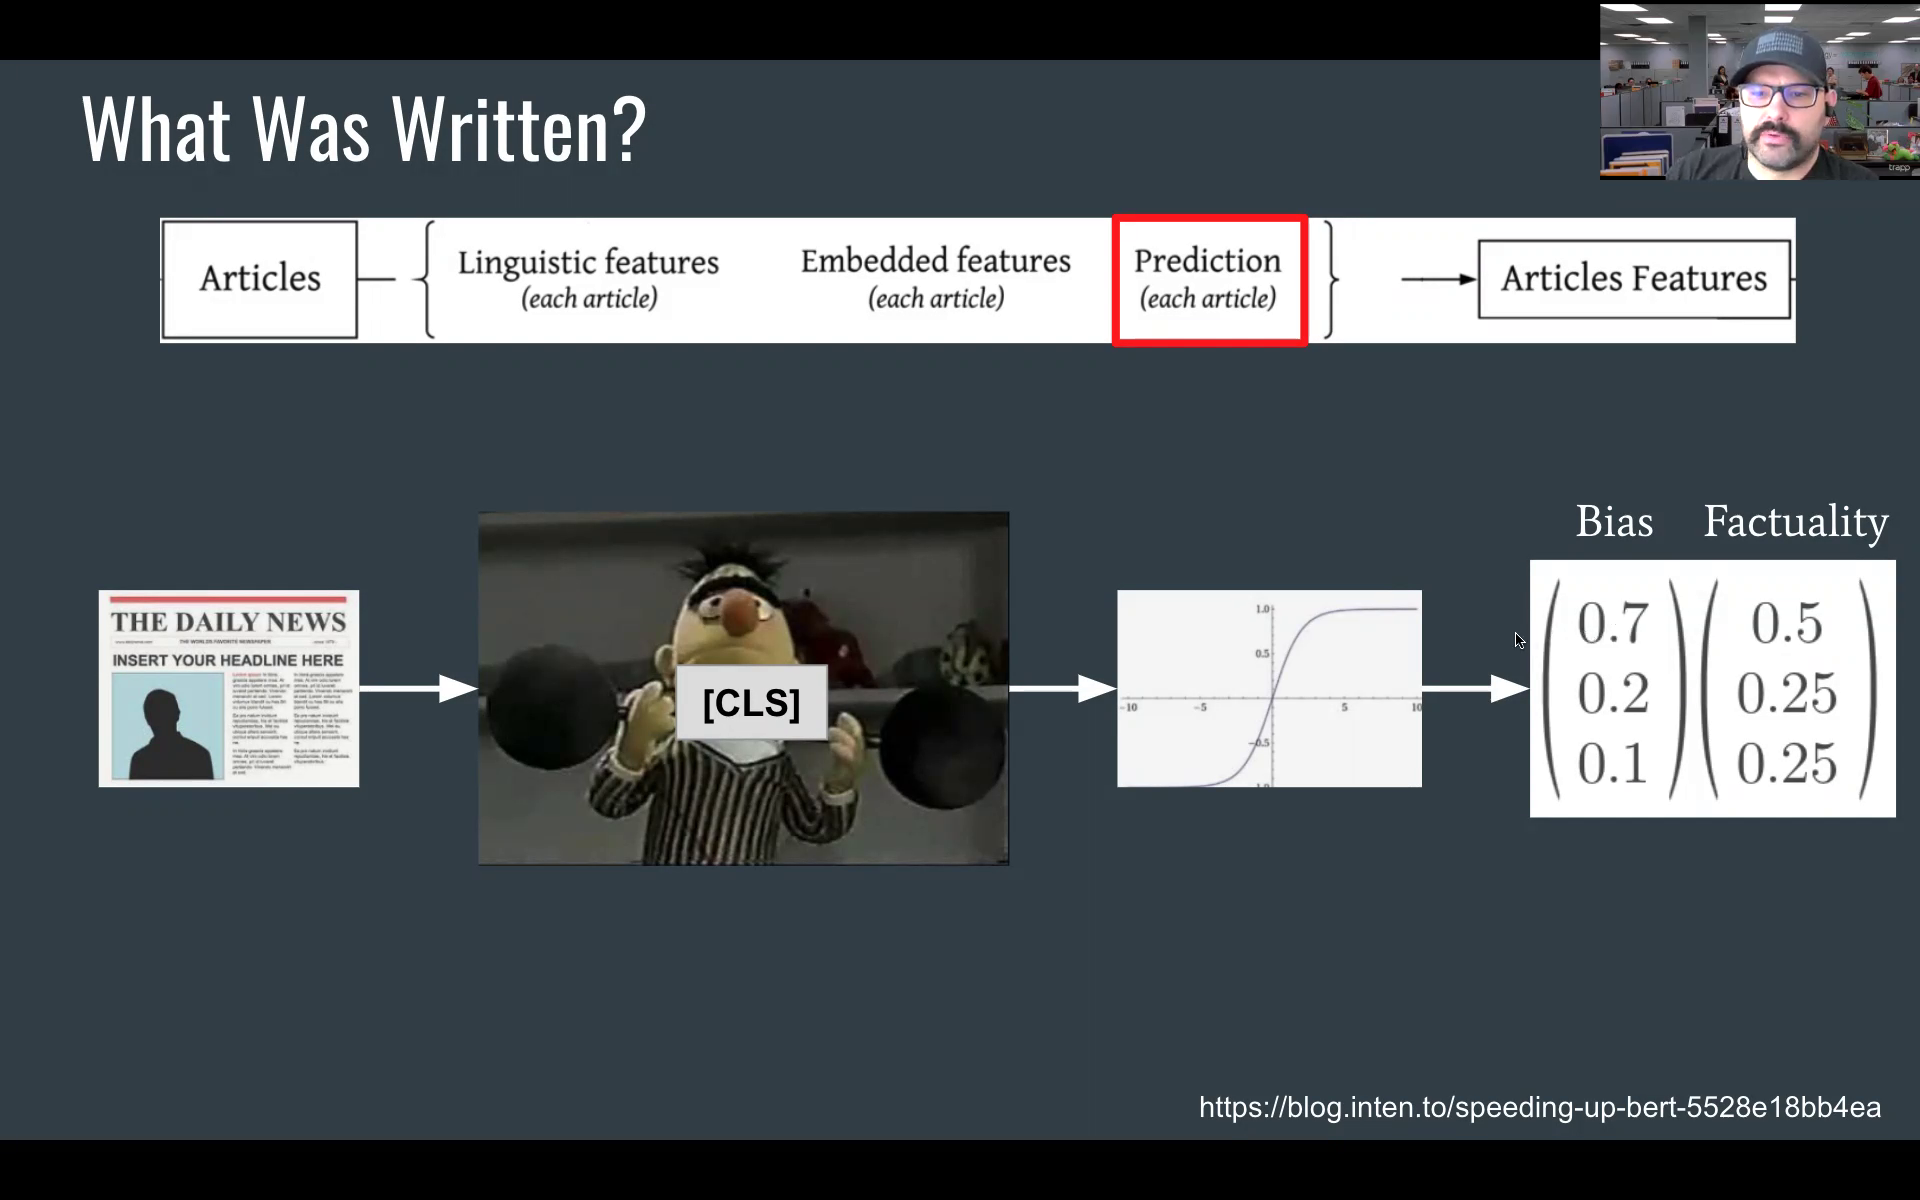

In [34]:
display(pil_image)

In [45]:
## 83512718053:  26343 (noise), 26353 (slide change), 26404 (noise), 18744 (noise)
vidcap.set(1, 18742)

True

In [46]:
success, pf = vidcap.read()
print(success)
success, f = vidcap.read()
print(success)
#pf = cv2.cvtColor(pf, cv2.COLOR_BGR2GRAY)
#f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
df = f - pf
print(cosine_similarity(pf.flatten()[np.newaxis, :], f.flatten()[np.newaxis, :]))

True
True
[[0.9999076]]


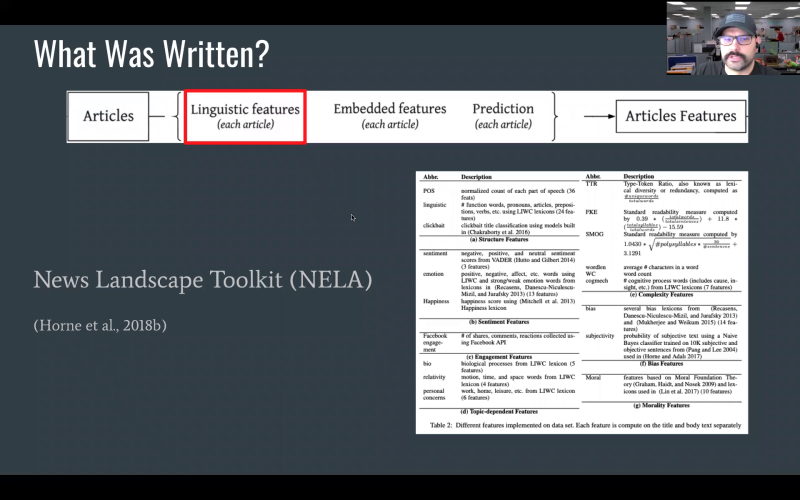

In [47]:
#color_coverted = pf
color_coverted = cv2.cvtColor(pf, cv2.COLOR_BGR2RGB)
pil_image_resized = Image.fromarray(imutils.resize(color_coverted, width=800))
display(pil_image_resized)

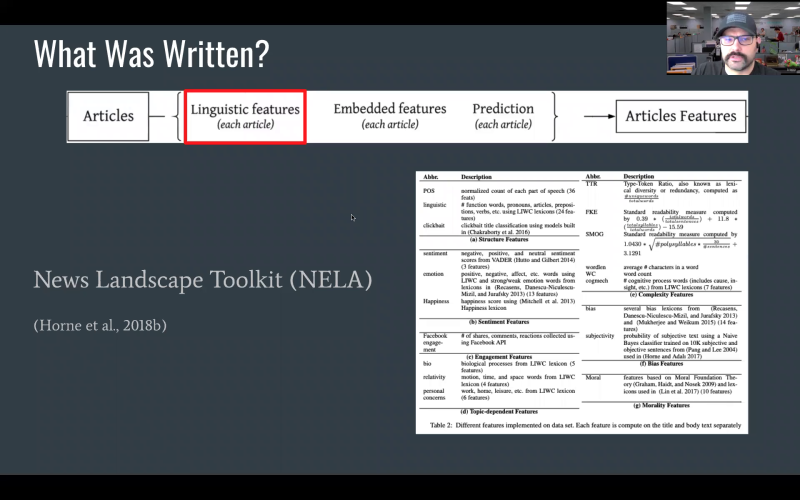

In [48]:
#color_coverted = f
color_coverted = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
pil_image_resized = Image.fromarray(imutils.resize(color_coverted, width=800))
display(pil_image_resized)

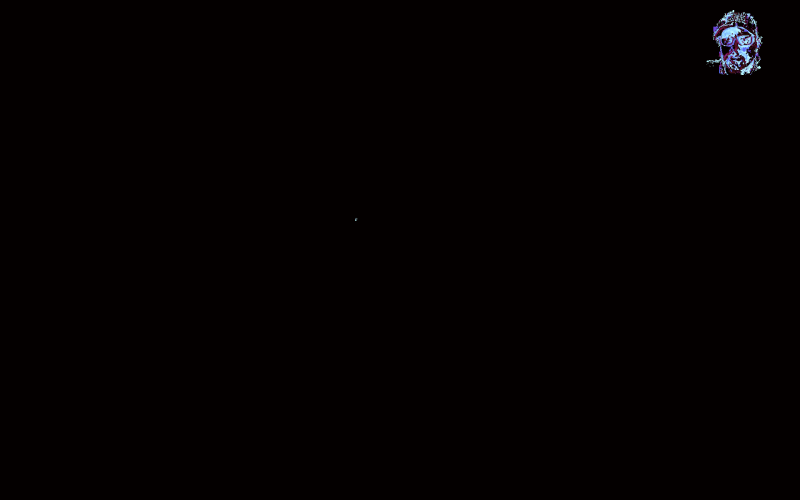

In [49]:
heatmap_img = cv2.applyColorMap(df, cv2.COLORMAP_MAGMA)
heatmap_img_resized = Image.fromarray(imutils.resize(heatmap_img, width=800))
display(heatmap_img_resized)

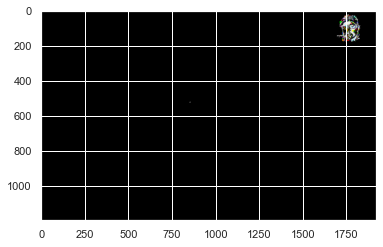

In [50]:
plt.imshow(df);

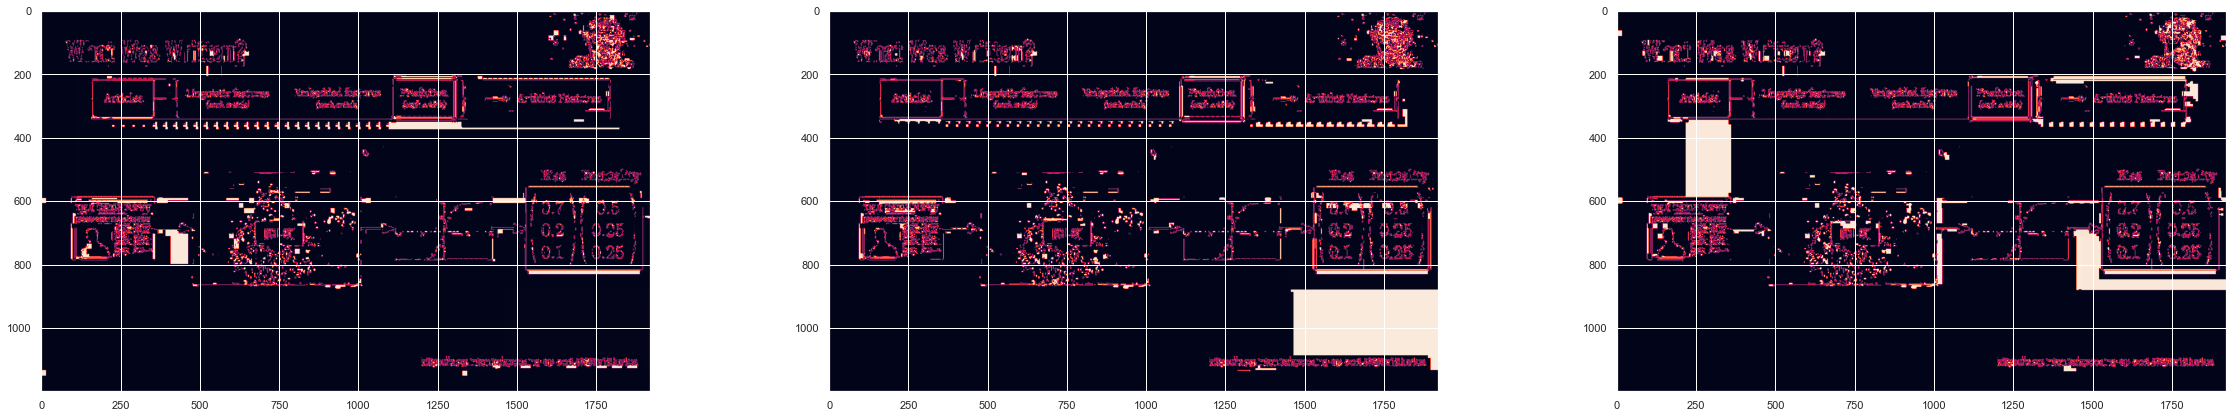

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(40, 7))
for i in range(3):
    ax[i].imshow(df[:,:,i])

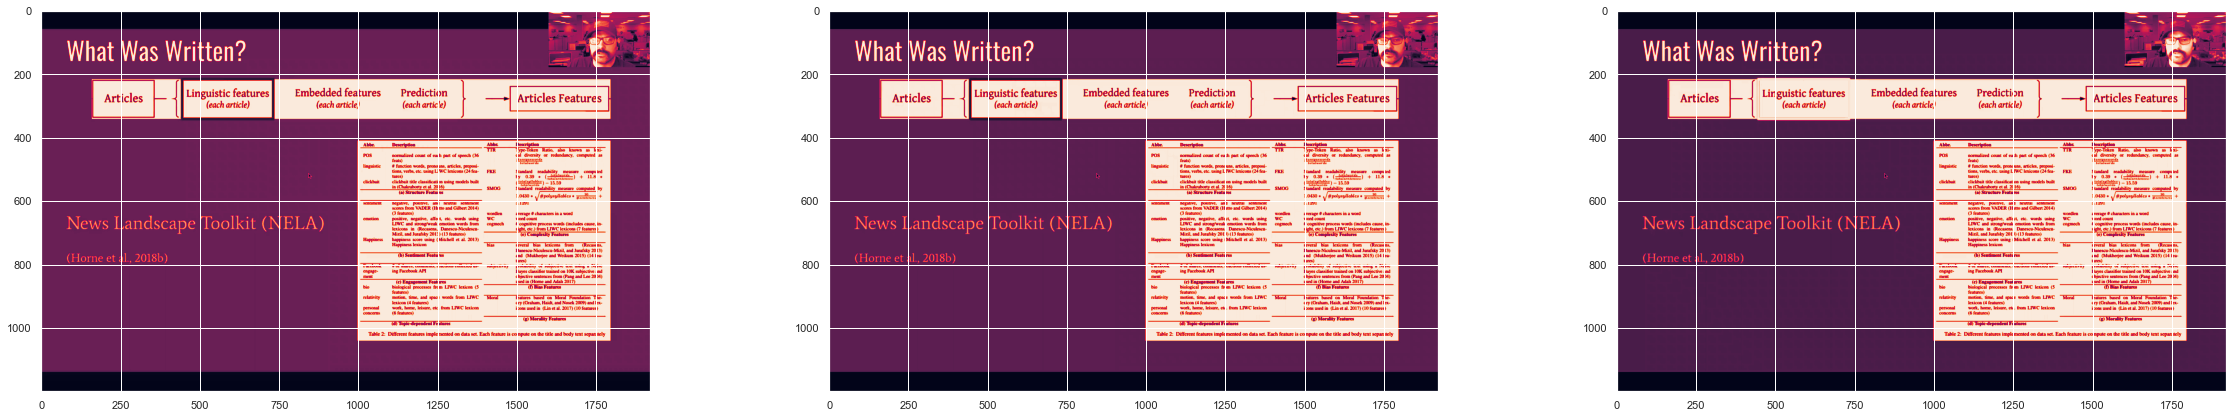

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(40, 7))
for i in range(3):
    ax[i].imshow(pf[:,:,i])

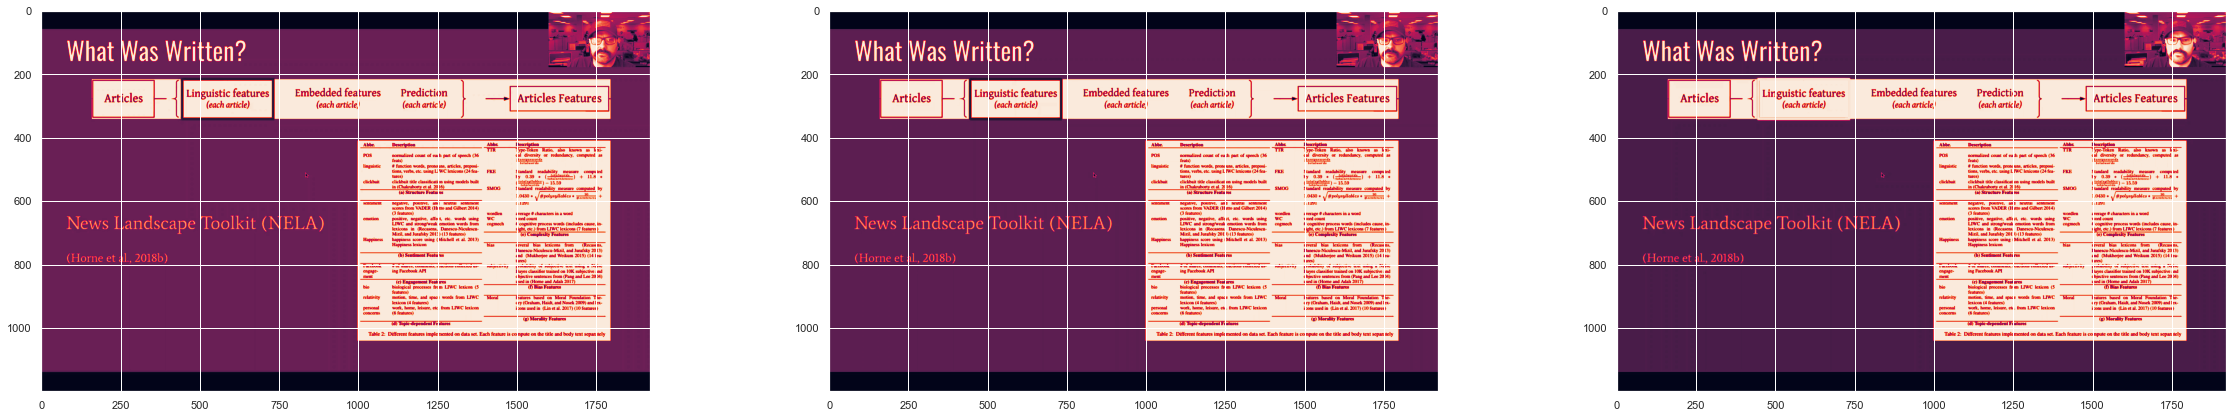

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(40, 7))
for i in range(3):
    ax[i].imshow(f[:,:,i])

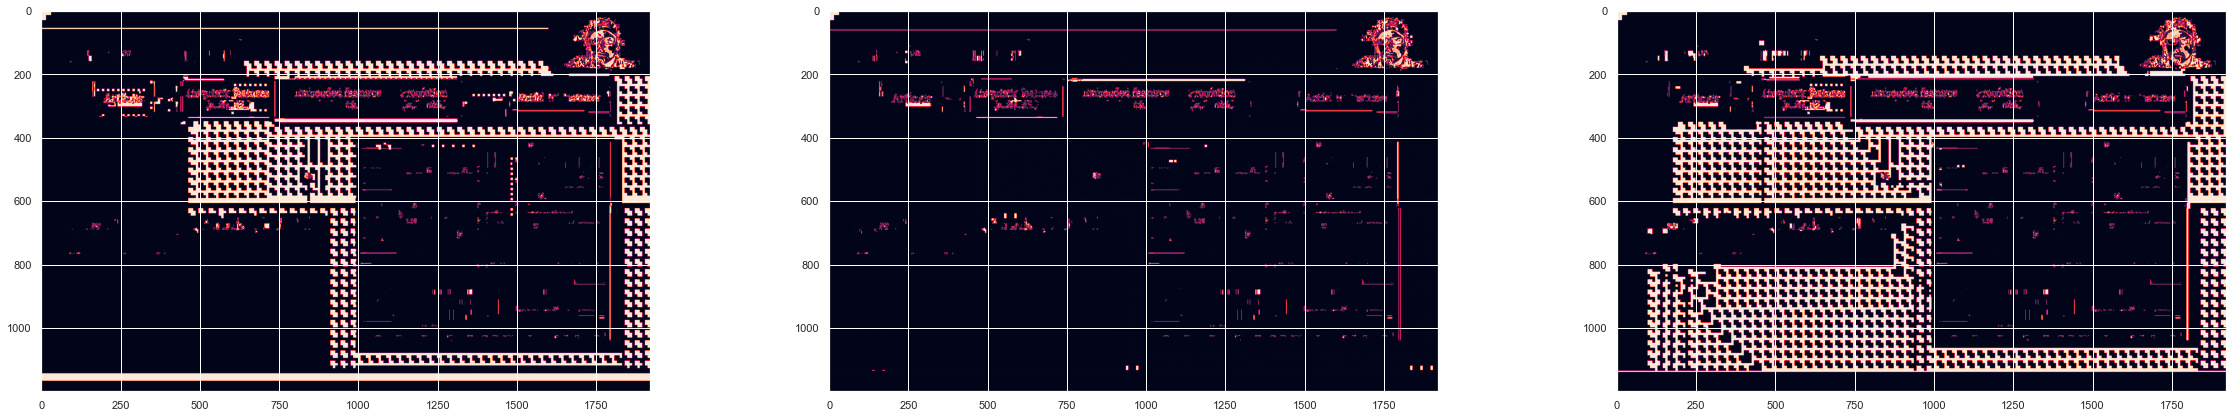

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(40, 7))
for i in range(3):
    ax[i].imshow(f[:,:,i] - pf[:,:,i])

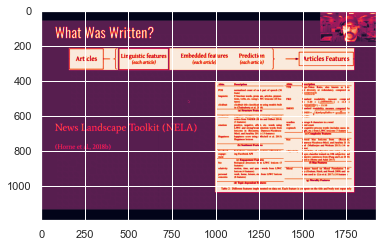

In [23]:
plt.imshow(pf)

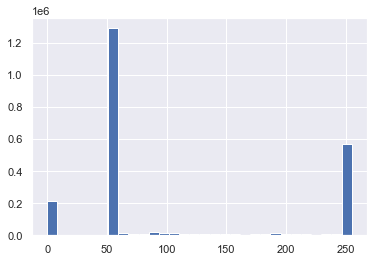

In [36]:
plt.hist(pf.flatten(), bins=30)
plt.show()

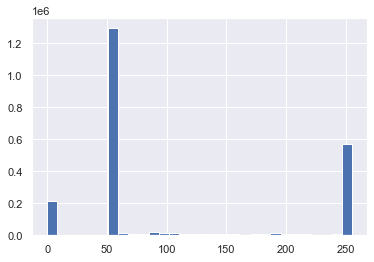

In [37]:
plt.hist(f.flatten(), bins=30)
plt.show()

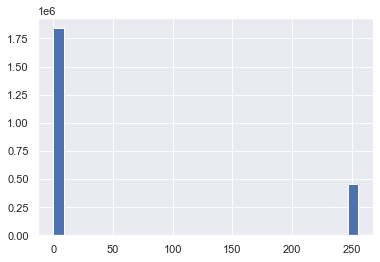

In [38]:
plt.hist(df.flatten(), bins=30)
plt.show()

In [52]:
heatmap_img[100,100,:]

array([128,   0,   0], dtype=uint8)

In [47]:
pf[100,100,:]

array([69, 61, 49], dtype=uint8)

In [48]:
f[100,100,:]

array([69, 61, 49], dtype=uint8)

In [53]:
df[100,100,:]

array([0, 0, 0], dtype=uint8)

In [188]:
df

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Shape Detection

### Get mask proportions

In [4]:
meetings = [160320, 220120, 170127, 83512718053]
mask_coords = {
    160320: (180, 1700), 
    220120: (180, 1600), 
    170127: (180, 2030), 
    83512718053: (180, 1600)
}

In [5]:
for meeting in meetings:
    video_path = glob.glob(f'zoom_data/{meeting}/*.mp4')[0]
    vidcap = VideoCapture(video_path)
    success, f = vidcap.read()
    y, x = mask_coords[meeting]
    print(f"{meeting}: {f.shape[:2]} - ({y / f.shape[0]:.3f}, {1 - (x / f.shape[1]):.3f})")

160320: (1380, 2020) - (0.130, 0.158)
220120: (1170, 1920) - (0.154, 0.167)
170127: (1322, 2350) - (0.136, 0.136)
83512718053: (1200, 1920) - (0.150, 0.167)


### Manually mask frame

160320: f[:180,1700:,:] -> (0.13, 0.158)

83512718053: f[:180,1600:,:] -> (0.154, 0.167)

170127: f[:180,2030:,:] -> (0.136, 0.136)

220120: f[:180,1600:,:] -> (0.15, 0.167)

# Inspect masks

In [4]:
#meeting_id = 160320
meeting_id = 83512718053
#meeting_id = 220120
#meeting_id = 170127

In [5]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)

zoom_data/83512718053/GMT20210527-002121_Recording_1920x1200.mp4


In [6]:
vidcap = VideoCapture(video_path)

In [11]:
vidcap.set(1, 20000)

True

In [12]:
success, f = vidcap.read()
print(success)

True


In [13]:
f.shape

(1200, 1920, 3)

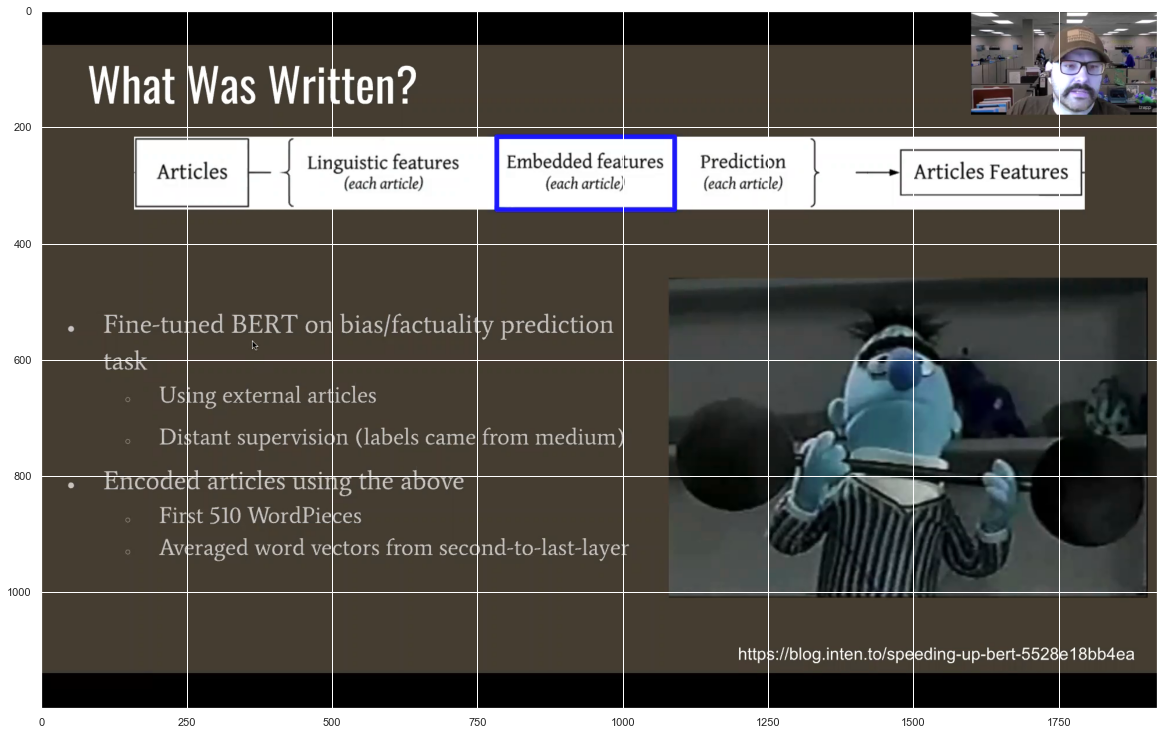

In [14]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))
ax.imshow(f)
plt.show()

In [15]:
# Manual masks
#y, x = mask_coords[meeting]

# General masks
pct_x = 0.17
pct_y = 0.16
x = int(f.shape[1] * (1 - pct_x))
y = int(f.shape[0] * pct_y)
print(y, x)

# Apply mask
f[:y,x:,:] = 0

192 1593


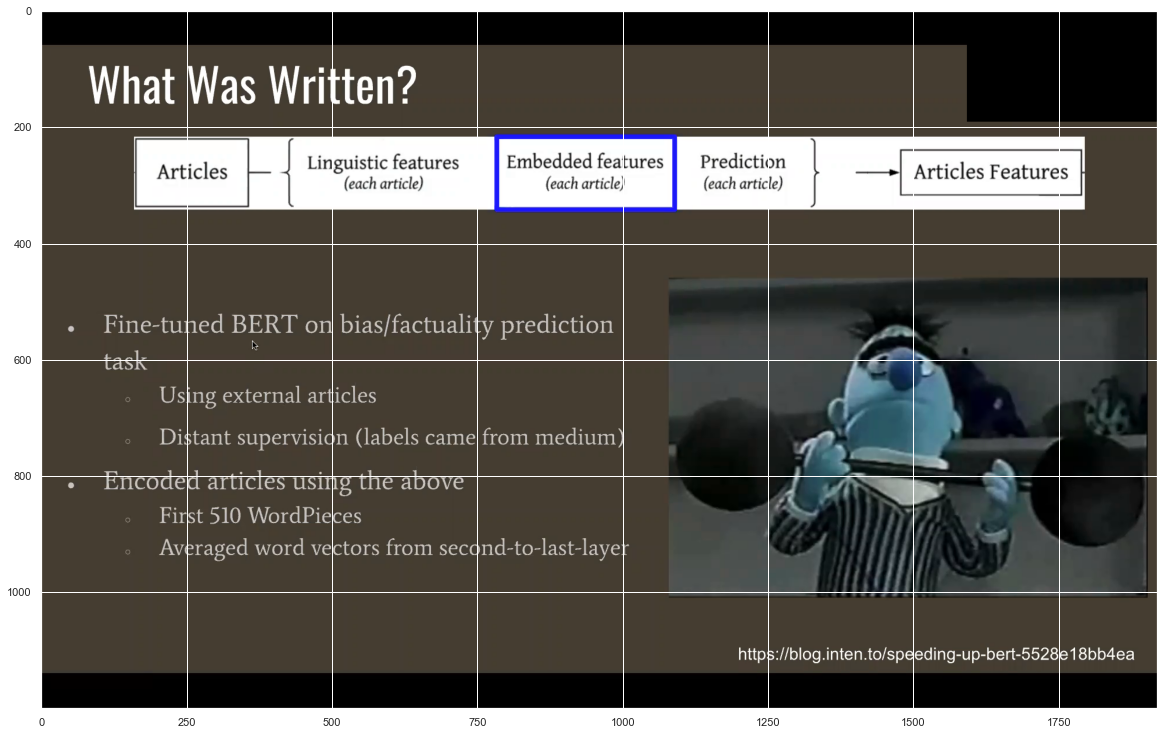

In [16]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))
ax.imshow(f)
plt.show()